In [39]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from random import randint
import time, os
import utils
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from torchvision.transforms import transforms
import requests
from os.path import dirname, exists
from os import makedirs
import pandas as pd
import math
import cv2

ModuleNotFoundError: No module named 'cv2'

In [78]:
# dataset image path
train_img_path = '../dog_dataset/train_64x64'
test_img_path = '../dog_dataset/test_64x64'

# rgb dataset .pt path
train_data=torch.load('../dog_dataset/train_data_final.pt')
train_label=torch.load('../dog_dataset/train_label_final.pt')
test_data=torch.load('../dog_dataset/test_data_final.pt')
test_label=torch.load('../dog_dataset/test_label_final.pt')

# Dataset Collection #

Generate scraper to download the images from https://dog.ceo/dog-api/ for all the breeds to form our raw dataset.

In [ ]:
project_path = dirname(__file__)
data_dir = project_path + "/data"
if not exists(data_dir):
    makedirs(data_dir)


breed_url = "https://dog.ceo/api/breeds/list/all"
breed_response = requests.get(breed_url)
breed_dict = breed_response.json().get('message')
single_breed = [x for x in breed_dict if len(breed_dict.get(x)) == 0]
multi_breed = [i+"/"+j for i in breed_dict for j in breed_dict.get(i) if len(breed_dict.get(i)) > 0]
breed_lst = single_breed + multi_breed


def get_img_url(breed):
    url = f"https://dog.ceo/api/breed/{breed}/images"
    img_response = requests.get(url)
    img_lst = img_response.json().get('message')
    if not exists(f"{data_dir}/{breed}"):
        makedirs(f"{data_dir}/{breed}")
    for i in img_lst:
        download_img(breed, i)


def download_img(breed, url):
    response = requests.get(url)
    with open(f"{data_dir}/{breed}/{url.split('/')[-1]}", "wb") as file:
        file.write(response.content)


for i in breed_lst:
    get_img_url(i)


# Exploratory Data Analysis And Data Preprocessing #

## First Look of the Raw Dataset ##

A glance of the raw dataset downloaded from Dog API using the scraper 
<div>
    <img src="report_attachment/raw_data_look.png" width='500' align='left'>
</div>

In [53]:
raw_data_path = '../data'
print('Total number of breeds in the raw dataset: ', len([i for i in os.listdir(raw_data_path)]))

Total number of breeds in the raw dataset:  91


## Dataset Preperation ##

There are in total 91 dog breeds in the raw dataset.  
However, the data sizes for each breed are varing from a dozen to more than a hundred.  
To create a balanced dataset, we have filtered **10 most popular dog breeds** out of the list and with data size **more than 100 images** .  
Below is the list of dog breeds to be classified in our classsifier.

In [79]:
# list of dog breeds to be classified in our dog classifier
dog_dict = {
    'affenpinscher':0,
    'beagle':1,
    'boxer':2,
    'chihuahua':3,
    'frenchbulldog':4,
    'goldenretriever':5,
    'rottweiler':6,
    'schnauzer':7,
    'sheepdog':8,
    'spaniel':9
}

To improve the quality of the dataset, we screen through the images and unsuitable images are removed from the dataset, e.g., images with vague objects.  
After data cleaning, the dataset is seperated into 2 sets: train set and test set with balanced class distribution.

In [80]:
print('train set size: ', train_data.size()[0])
print('test set size: ', test_data.size()[0])

train set size:  979
test set size:  100


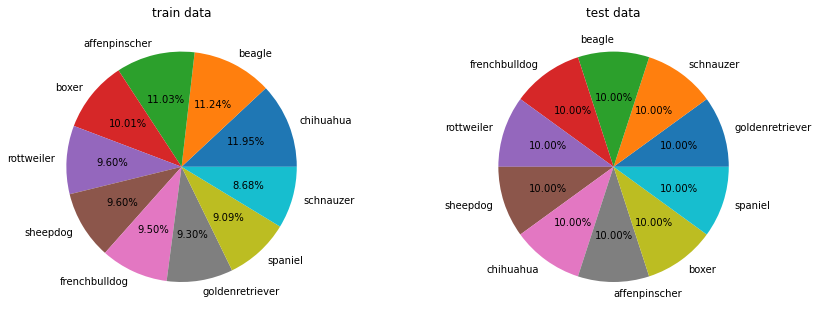

In [81]:
fig = plt.figure()

# train data class distribution
ax1 = fig.add_axes([0, 0, 1, 1], aspect=1)
plt.title("train data")
data = train_label.numpy()
data = pd.Series(data).value_counts()
label_num = data.index.tolist()
label = []
for i in range(len(label_num)):
    label.append([k for k, v in dog_dict.items() if v == label_num[i]])
label = np.asarray(label).squeeze()
ax1.pie(data, labels = label, autopct='%.2f%%')

# test data class distribution
ax2 = fig.add_axes([1, .0, 1, 1], aspect=1)
plt.title("test data")
data = test_label.numpy()
data = pd.Series(data).value_counts()
label_num = data.index.tolist()
label = []
for i in range(len(label_num)):
    label.append([k for k, v in dog_dict.items() if v == label_num[i]])
label = np.asarray(label).squeeze()
ax2.pie(data, labels = label, autopct='%.2f%%')
plt.show()

## Data Preprocessing ##

 ### Crop Images ###

Manually crop dataset images to 1:1 with clear and complete object

### Create Different Dataset with Corresponding Label ###

#### 64x64 RGB Dataset ####

In [83]:
# resize rgb data to 64x64
resize_norm = img_trans = transforms.Compose([transforms.Resize([64,64]),
                                              transforms.ToTensor()])
    
# train data
train_data = torch.Tensor([])
train_label = []
for img in os.listdir(train_img_path):
    pic_data = []
    breed = img.split('_')[0]
    pic_label = dog_dict[breed]
    train_label.append(pic_label)
    pic = Image.open(os.path.join(train_img_path,img)) 
    trans_pic = resize_norm(pic)
    trans_pic = torch.unsqueeze(trans_pic, dim=0)
    train_data = torch.cat((train_data, trans_pic),0)
    
# test data
test_data = torch.Tensor([])
test_label = []
for img in os.listdir(test_img_path):
    pic_data = []
    breed = img.split('_')[0]
    pic_label = dog_dict[breed]
    test_label.append(pic_label)
    pic = Image.open(os.path.join(test_img_path,img)) 
    trans_pic = resize_norm(pic)
    trans_pic = torch.unsqueeze(trans_pic, dim=0)
    test_data = torch.cat((test_data, trans_pic),0)

# change label from list to tensor
train_label = torch.tensor(train_label)
test_label = torch.tensor(test_label)

# save train data and label to .pt file
torch.save(train_data, '../dog_dataset/train_data_final.pt')
torch.save(train_label, '../dog_dataset/train_label_final.pt')
torch.save(test_data, '../dog_dataset/test_data_final.pt')
torch.save(test_label, '../dog_dataset/test_label_final.pt')

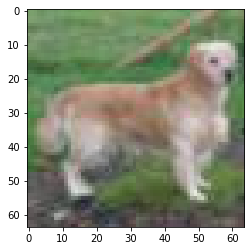

In [89]:
utils.show(train_data[4])

#### 64x64 Grayscale Dataset ####

In [84]:
# rgb to gray
rgb_to_gray = transforms.Compose([transforms.Resize([64,64]),
                                  transforms.Grayscale(num_output_channels=1),
                                  transforms.ToTensor()])

# train data
train_data_gray = torch.Tensor([])
train_label_gray = []
for img in os.listdir(train_img_path):
    pic_data = []
    breed = img.split('_')[0]
    pic_label = dog_dict[breed]
    train_label_gray.append(pic_label)
    pic = Image.open(os.path.join(train_img_path,img))
    pic = rgb_to_gray(pic)
    train_data_gray = torch.cat((train_data_gray, pic),0)
    
# test data
test_data_gray = torch.Tensor([])
test_label_gray = []
for img in os.listdir(test_img_path):
    pic_data = []
    breed = img.split('_')[0]
    pic_label = dog_dict[breed]
    test_label_gray.append(pic_label)
    pic = Image.open(os.path.join(test_img_path,img))
    pic = rgb_to_gray(pic)
    test_data_gray = torch.cat((test_data_gray, pic),0)
    
# change label from list to tensor
train_label_gray = torch.tensor(train_label_gray)
test_label_gray = torch.tensor(test_label_gray)
    
# save train data and label to .pt file
torch.save(train_data_gray, '../dog_dataset/train_data_gray.pt')
torch.save(train_label_gray, '../dog_dataset/train_label_gray.pt')
torch.save(test_data_gray, '../dog_dataset/test_data_gray.pt')
torch.save(test_label_gray, '../dog_dataset/test_label_gray.pt')

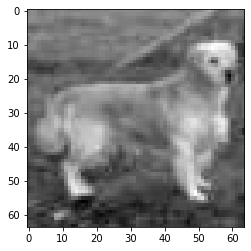

In [88]:
utils.show(train_data_gray[4])

#### 64x64 Image Augmentation ####

In [91]:
# image augmentation
img_augmentation = transforms.Compose([transforms.Resize([64,64]),
                                        transforms.RandomHorizontalFlip(),
                                        transforms.ColorJitter(brightness=0.3, contrast=0.3),
                                        transforms.ToTensor()])

#train data
train_data_aug = torch.Tensor([])
train_label_aug = []
for img in os.listdir(train_img_path):
    pic_data = []
    breed = img.split('_')[0]
    pic_label = dog_dict[breed]
    train_label_aug.append(pic_label)
    pic = Image.open(os.path.join(train_img_path,img)) 
    trans_pic = img_augmentation(pic)
    trans_pic = torch.unsqueeze(trans_pic, dim=0)
    train_data_aug = torch.cat((train_data_aug, trans_pic),0)
    
# change label from list to tensor
train_label_aug = torch.tensor(train_label_aug)

# save test data and label to .pt file
torch.save(train_data_aug, '../dog_dataset/train_data_aug.pt')
torch.save(train_label_aug, '../dog_dataset/train_label_aug.pt')

Create augmented dataset by random flip, brightness and contrast adjustment.  
(top: original data, bottom: augmented data)  
<div>
    <img src="report_attachment/image_aug_compare.png" width='250' align='left'>
</div>

## MLP

In [19]:
device= torch.device("cuda")
print(device)

cuda


### Load RGD Dataset

In [20]:
dataset_folder=''
train_data=torch.load(dataset_folder+'train_data_final.pt')
print(train_data.size())

test_data=torch.load(dataset_folder+'test_data_final.pt')
print(test_data.size())

train_label=torch.load(dataset_folder+'train_label_final.pt')
print(train_label.size())

test_label=torch.load(dataset_folder+'test_label_final.pt')
print(test_label.size())

torch.Size([979, 3, 64, 64])
torch.Size([100, 3, 64, 64])
torch.Size([979])
torch.Size([100])


In [21]:
class three_layer_net(nn.Module):

    def __init__(self, input_size, hidden_size1, hidden_size2, hidden_size3,output_size):
        super(three_layer_net , self).__init__()

        self.layer1 = nn.Linear(  input_size   , hidden_size1  , bias=False  )
        self.layer2 = nn.Linear(  hidden_size1 , hidden_size2  , bias=False  )
        self.layer3 = nn.Linear(  hidden_size2 , hidden_size3  , bias=False  )
        self.layer4 = nn.Linear(  hidden_size3 , output_size   , bias=False  )        
        
    def forward(self, x):
        
        y       = self.layer1(x)
        y_hat   = torch.relu(y)
        z       = self.layer2(y_hat)
        z_hat   = torch.relu(z)
        a       = self.layer3(z_hat)
        a_hat   = torch.relu(a)
        scores  = self.layer4(a_hat)
        
        return scores

In [22]:
net=three_layer_net(12288,500,500,500,11)
print(net)
criterion = nn.CrossEntropyLoss()
optimizer=torch.optim.SGD( net.parameters() , lr=0.01 )
bs= 10

three_layer_net(
  (layer1): Linear(in_features=12288, out_features=500, bias=False)
  (layer2): Linear(in_features=500, out_features=500, bias=False)
  (layer3): Linear(in_features=500, out_features=500, bias=False)
  (layer4): Linear(in_features=500, out_features=11, bias=False)
)


In [23]:
def eval_on_test_set_mlp():

    running_error=0
    num_batches=0


    for i in range(0,100,bs):

        # extract the minibatch
        minibatch_data =  test_data[i:i+bs]
        minibatch_label= test_label[i:i+bs]
        # send them to the gpu
        #minibatch_data=minibatch_data.to(device)
        #minibatch_label=minibatch_label.to(device)

        # reshape the minibatch
        inputs = minibatch_data.view(bs,12288)

        # feed it to the network
        scores=net( inputs ) 

        # compute the error made on this batch
        error = utils.get_error( scores , minibatch_label)

        # add it to the running error
        running_error += error.item()

        num_batches+=1


    # compute error rate on the full test set
    total_error = running_error/num_batches

    print( 'error rate on test set =', total_error*100 ,'percent')

In [24]:
start=time.time()

for epoch in range(10):
    
    running_loss=0
    running_error=0
    num_batches=0
    
    shuffled_indices=torch.randperm(970)
 
    for count in range(0,970,bs):
    
        # Set the gradients to zeros
        optimizer.zero_grad()
        
        # create a minibatch       
        indices=shuffled_indices[count:count+bs]
        minibatch_data =  train_data[indices]
        minibatch_label=  train_label[indices]
        
        # send them to the gpu
        #minibatch_data=minibatch_data.to(device)
        #minibatch_label=minibatch_label.to(device)
        
        # reshape the minibatch
        inputs = minibatch_data.view(bs,12288)

        # tell Pytorch to start tracking all operations that will be done on "inputs"
        inputs.requires_grad_()

        # forward the minibatch through the net 
        scores=net( inputs ) 

        # Compute the average of the losses of the data points in the minibatch
        loss =  criterion( scores , minibatch_label) 
        
        # backward pass to compute dL/dU, dL/dV and dL/dW   
        loss.backward()

        # do one step of stochastic gradient descent: U=U-lr(dL/dU), V=V-lr(dL/dU), ...
        optimizer.step()
        

        # START COMPUTING STATS
        
        # add the loss of this batch to the running loss
        running_loss += loss.detach().item()
        
        # compute the error made on this batch and add it to the running error       
        error = utils.get_error( scores.detach() , minibatch_label)
        running_error += error.item()
        
        num_batches+=1        
    
    
    # compute stats for the full training set
    total_loss = running_loss/num_batches
    total_error = running_error/num_batches
    elapsed = time.time()-start
    
#if epoch%2 == 0:
    print('epoch=',epoch, '\t time=', elapsed, '\t loss=', total_loss , '\t error=', total_error*100 ,'percent')
    eval_on_test_set_mlp() 
    print(' ')

epoch= 0 	 time= 0.4412417411804199 	 loss= 2.3636210161386075 	 error= 88.65979313850403 percent
error rate on test set = 86.99999868869781 percent
 
epoch= 1 	 time= 0.8581478595733643 	 loss= 2.2861991690606187 	 error= 83.40206121661 percent
error rate on test set = 81.99999868869781 percent
 
epoch= 2 	 time= 1.2627465724945068 	 loss= 2.1917054100134936 	 error= 79.4845359227092 percent
error rate on test set = 83.99999976158142 percent
 
epoch= 3 	 time= 1.6771886348724365 	 loss= 2.0970236812670207 	 error= 77.01030920461281 percent
error rate on test set = 75.0 percent
 
epoch= 4 	 time= 2.1073405742645264 	 loss= 2.049530719973377 	 error= 74.74226785689285 percent
error rate on test set = 79.00000035762787 percent
 
epoch= 5 	 time= 2.5222604274749756 	 loss= 2.0038245400202643 	 error= 76.08247423909374 percent
error rate on test set = 69.99999940395355 percent
 
epoch= 6 	 time= 2.94783353805542 	 loss= 1.9811773767176362 	 error= 73.71133977604896 percent
error rate on te

## CNN for Dog Breed Classification

In [25]:
class Vgg_convnet(nn.Module):

    def __init__(self):

        super(Vgg_convnet, self).__init__()

        # block 1:         3 x 64 x 64 --> 64 x 32 x 32        
        self.conv1a = nn.Conv2d(3,   64,  kernel_size=8, padding=4 )
        # self.conv1b = nn.Conv2d(64,  64,  kernel_size=3, padding=1 )
        self.pool1  = nn.MaxPool2d(2,2)

        # block 2:         64 x 32 x 32 --> 128 x 16 x 16
        self.conv2a = nn.Conv2d(64,  128, kernel_size=4, padding=2 )
        # self.conv2b = nn.Conv2d(128, 128, kernel_size=3, padding=1 )
        self.pool2  = nn.MaxPool2d(2,2)

        # block 3:         128 x 16 x 16 --> 256 x 8 x 8        
        self.conv3a = nn.Conv2d(128, 256, kernel_size=3, padding=1 )
        # self.conv3b = nn.Conv2d(256, 256, kernel_size=3, padding=1 )
        self.pool3  = nn.MaxPool2d(2,2)
        
        #block 4:          256 x 8 x 8 --> 512 x 4 x 4
        self.conv4a = nn.Conv2d(256, 512, kernel_size=3, padding=1 )
        self.pool4  = nn.MaxPool2d(2,2)

        #block 5:          512 x 4 x 4 --> 512 x 2 x 2
        self.conv5a = nn.Conv2d(512, 512, kernel_size=3, padding=1 )
        self.pool5  = nn.MaxPool2d(2,2)

        # linear layers:   512 x 2 x 2 --> 32768 --> 4096 --> 4096 --> 10
        self.linear1 = nn.Linear(2048, 8192)
        self.linear2 = nn.Linear(8192,8192)
        self.linear3 = nn.Linear(8192, 10)


    def forward(self, x):

        # block 1:         3 x 32 x 32 --> 64 x 16 x 16
        x = self.conv1a(x)
        x = torch.relu(x)
        x = self.pool1(x)

        # block 2:         64 x 16 x 16 --> 128 x 8 x 8
        x = self.conv2a(x)
        x = torch.relu(x)

        x = self.pool2(x)

        # block 3:         128 x 8 x 8 --> 256 x 4 x 4
        x = self.conv3a(x)
        x = torch.relu(x)
        x = self.pool3(x)

        #block 4:          256 x 4 x 4 --> 512 x 2 x 2
        x = self.conv4a(x)
        x = torch.relu(x)
        x = self.pool4(x)

        #block 5:          256 x 4 x 4 --> 256 x 2 x 2
        x = self.conv5a(x)
        x = torch.relu(x)
        x = self.pool5(x)

        # linear layers:   512 x 2 x 2 --> 2048 --> 4096 --> 4096 --> 10
        x = x.view(-1, 2048)
        x = self.linear1(x)
        x = torch.relu(x)
        x = self.linear2(x)
        x = torch.relu(x)
        x = self.linear3(x) 
        
        return x

In [26]:
class LeNet5_convnet(nn.Module):

    def __init__(self):

        super(LeNet5_convnet, self).__init__()

        # CL1:   3 x 64 x 64  -->    50 x 64 x 64 
        self.conv1 = nn.Conv2d(3,   50,  kernel_size=3,  padding=1 )
        
        # MP1: 50 x 64 x 64 -->    50 x 32 x 32
        self.pool1  = nn.MaxPool2d(2,2)
        
        # CL2:   50 x 32 x 32  -->    100 x 32 x 32 
        self.conv2 = nn.Conv2d(50,  100,  kernel_size=3,  padding=1 )
        
        # MP2: 100 x 32 x 32 -->    100 x 16 x 16
        self.pool2 = nn.MaxPool2d(2,2)
        
        # LL1:   100 x 7 x 7 = 4900 -->  100 
        self.linear1 = nn.Linear(25600, 100)
        
        # LL2:   100  -->  10 
        self.linear2 = nn.Linear(100,10)


    def forward(self, x):

        # CL1:   28 x 28  -->    50 x 28 x 28 
        x = self.conv1(x)
        x = F.relu(x)
        
        # MP1: 50 x 28 x 28 -->    50 x 14 x 14
        x = self.pool1(x)
        
        # CL2:   50 x 14 x 14  -->    100 x 14 x 14
        x = self.conv2(x)
        x = F.relu(x)
        
        # MP2: 100 x 14 x 14 -->    100 x 7 x 7
        x = self.pool2(x)

        # LL1:   100 x 7 x 7 = 4900  -->  100 
        x = x.view(-1, 25600)
        x = self.linear1(x)
        x = F.relu(x)
        
        # LL2:   4900  -->  10 
        x = self.linear2(x)
    
        return x

In [27]:
mean= train_data.mean()
print(mean)
std= train_data.std()
print(std)

tensor(0.4272)
tensor(0.2518)


In [28]:
net=Vgg_convnet()

print(net)
utils.display_num_param(net)

Vgg_convnet(
  (conv1a): Conv2d(3, 64, kernel_size=(8, 8), stride=(1, 1), padding=(4, 4))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2a): Conv2d(64, 128, kernel_size=(4, 4), stride=(1, 1), padding=(2, 2))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3a): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv4a): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv5a): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (linear1): Linear(in_features=2048, out_features=8192, bias=True)
  (linear2): Linear(in_features=8192, out_features=8192, bias=True)
  (linear3): Linear(in_fe

In [29]:
net = net.to(device)
mean = mean.to(device)
std = std.to(device)

In [30]:
criterion = nn.CrossEntropyLoss()
my_lr=0.01 
bs= 16
num_epoch=10

In [31]:
def eval_on_test_set_cnn():

    running_error=0
    num_batches=0

    for i in range(0,100,bs):

        minibatch_data =  test_data[i:i+bs]
        minibatch_label= test_label[i:i+bs]

        minibatch_data=minibatch_data.to(device)
        minibatch_label=minibatch_label.to(device)
        
        inputs = (minibatch_data - mean)/std
        scores=net( inputs ) 
        error = utils.get_error( scores , minibatch_label)
        running_error += error.item()

        num_batches+=1

    total_error = running_error/num_batches
    print( 'error rate on test set =', total_error*100 ,'percent')

In [32]:
start=time.time()

for epoch in range(1,num_epoch):
    
    # divide the learning rate by 2 at epoch 10, 14 and 18
    #if epoch % 25 == 0: 
        #my_lr = my_lr/2
    
    # create a new optimizer at the beginning of each epoch: give the current learning rate.   
    optimizer=torch.optim.SGD( net.parameters() , lr=my_lr )
    #optimizer = torch.optim.Adam(net.parameters(), lr=my_lr)
    # set the running quatities to zero at the beginning of the epoch
    running_loss=0
    running_error=0
    num_batches=0
    
    # set the order in which to visit the image from the training set
    shuffled_indices=torch.randperm(979)
 
    for count in range(0,979,bs):
    
        # Set the gradients to zeros
        optimizer.zero_grad()
        
        # create a minibatch       
        indices=shuffled_indices[count:count+bs]
        minibatch_data =  train_data[indices]
        minibatch_label=  train_label[indices]
        
        # send them to the gpu
        minibatch_data=minibatch_data.to(device)
        minibatch_label=minibatch_label.to(device)  

        inputs = (minibatch_data - mean)/std
        inputs.requires_grad_()
        scores=net( inputs )
        loss =  criterion( scores , minibatch_label)  
        loss.backward()

        optimizer.step() 

        # START COMPUTING STATS       
        # add the loss of this batch to the running loss
        running_loss += loss.detach().item()      
        error = utils.get_error( scores.detach() , minibatch_label)
        running_error += error.item()
        
        num_batches+=1        
    
    # compute stats for the full training set
    total_loss = running_loss/num_batches
    total_error = running_error/num_batches
    elapsed = (time.time()-start)/60
    
    if epoch%10 == 0:
        print('Epoch=',epoch, '\t time=', elapsed,'min','\t lr=', my_lr  ,'\t loss=', total_loss , '\t error=', total_error*100 ,'percent')
        eval_on_test_set_cnn() 
        print('-----------------------------')

## RNN Dog Breed Classificaiton on Gray Scale Images

In [33]:
# Hyper-parameters for RNN
seq_length = 64
input_size = 64
hidden_size = 256
num_layers = 2
num_classes = 10
bs = 50
learning_rate = 0.01
num_epochs=150

### Load Gray Scale Dataset

In [34]:
train_data_gray=torch.load(dataset_folder+'train_data_gray.pt')
print(train_data_gray.size())
test_data_gray=torch.load(dataset_folder+'test_data_gray.pt')
print(test_data_gray.size())


train_label_gray=torch.load(dataset_folder+'train_label_gray.pt')
print(train_label_gray.size())
test_label_gray=torch.load(dataset_folder+'test_label_gray.pt')
print(test_label_gray.size())
train_dataset_gray = [{'data': train_data_gray[i], 'label': train_label_gray[i]} for i in range(len(train_data_gray)) ]
test_dataset_gray = [{'data': test_data_gray[i], 'label': test_label_gray[i]} for i in range(len(test_data_gray)) ]

# Data loader
train_loader_gray = torch.utils.data.DataLoader(dataset=train_dataset_gray,
                                           batch_size=bs,
                                           shuffle=True)
test_loader_gray = torch.utils.data.DataLoader(dataset=test_dataset_gray,
                                          batch_size=bs,
                                          shuffle=False)

torch.Size([979, 64, 64])
torch.Size([100, 64, 64])
torch.Size([979])
torch.Size([100])


In [35]:
class RNN(nn.Module):
    
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.layer1 = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.layer2 = nn.Linear(hidden_size, num_classes)

    
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device) 
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        

        out, _ = self.layer1(x, (h0, c0))  # out: tensor of shape (batch_size, seq_length, hidden_size)
        
        out = self.layer2(out[:, -1, :])
        return out

In [36]:
def eval_on_test_set_rnn(net):
    running_loss = 0
    num_batches = 0
    num_prediction = 0
    num_correct_prediction = 0
    
    net.eval()
    for batch_id, batch in enumerate(test_loader_gray):
        
        batch_data_num = batch["data"].shape[0]
        num_prediction += batch_data_num
        
        minibatch_data =  batch["data"].to(device)
        minibatch_label = batch["label"].to(device)
                                  
        output  = net( minibatch_data)
        predicted_label = torch.argmax(output, dim=1)
        num_correct_prediction += torch.sum(minibatch_label == predicted_label).item()
                
        loss = criterion(  output ,  minibatch_label )    

        running_loss += loss.item()
        num_batches += 1        
    
    total_loss = running_loss/num_batches 
    accuracy = num_correct_prediction / num_prediction
    print(f'Test: exp(loss) = {math.exp(total_loss):.4f}\tTest accuracy = {(accuracy*100):.4f}')

In [37]:
hidden_size = 256
num_layers = 2
net=RNN(input_size, hidden_size, num_layers, num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)

In [40]:
start=time.time()
for epoch in range(num_epochs):
    
    # divide the learning rate by 3 except after the first epoch
#     if epoch >= 2:
#         learning_rate = learning_rate / 3
    
    # create a new optimizer at the beginning of each epoch: give the current learning rate.   
    optimizer=torch.optim.SGD( net.parameters() , lr=learning_rate )

    # set the running quatities to zero at the beginning of the epoch
    running_loss=0
    num_batches=0    
    net.train()
    num_prediction = 0
    num_correct_prediction = 0
    for batch_id, batch in enumerate(train_loader_gray):
        
        # Set the gradients to zeros
        optimizer.zero_grad()
        batch_data_num = batch["data"].shape[0]
        num_prediction += batch_data_num
        
        # create a minibatch
        # send them to the gpu
        minibatch_data =  batch["data"].to(device)
        minibatch_label = batch["label"].to(device)
        
        # forward the minibatch through the net        
        output  = net( minibatch_data)
        predicted_label = torch.argmax(output, dim = 1)
        num_correct_prediction += torch.sum(minibatch_label == predicted_label).item()
        
        # Compute the average of the losses of the data points in this huge batch
        loss = criterion(  output ,  minibatch_label )
        loss.backward()

        # do one step of stochastic gradient descent: R=R-lr(dL/dR), V=V-lr(dL/dV), ...
        utils.normalize_gradient(net)
        optimizer.step()
        
        # update the running loss  
        running_loss += loss.item()
        num_batches += 1
        
    accuracy = num_correct_prediction / num_prediction
    # compute stats for the full training set
    total_loss = running_loss / num_batches
    elapsed = time.time() - start
    
    if epoch%10 == 0:
        print(f'Epoch {epoch} \ttime = {elapsed:.3f}\tlr = {learning_rate}\nTrain: exp(loss) = {math.exp(total_loss):.4f}\tTrain accuracy = {(accuracy*100):.4f}')
        eval_on_test_set_rnn(net)
        print(f'-----------------------------------')

Epoch 0 	time = 0.336	lr = 0.01
Train: exp(loss) = 9.9867	Train accuracy = 12.0531
Test: exp(loss) = 10.0041	Test accuracy = 11.0000
-----------------------------------
Epoch 10 	time = 3.625	lr = 0.01
Train: exp(loss) = 9.8937	Train accuracy = 13.7896
Test: exp(loss) = 9.9843	Test accuracy = 13.0000
-----------------------------------
Epoch 20 	time = 6.924	lr = 0.01
Train: exp(loss) = 9.8201	Train accuracy = 14.7089
Test: exp(loss) = 9.8895	Test accuracy = 13.0000
-----------------------------------
Epoch 30 	time = 10.353	lr = 0.01
Train: exp(loss) = 9.6255	Train accuracy = 18.0797
Test: exp(loss) = 9.5822	Test accuracy = 15.0000
-----------------------------------
Epoch 40 	time = 13.626	lr = 0.01
Train: exp(loss) = 8.8947	Train accuracy = 18.9990
Test: exp(loss) = 8.4668	Test accuracy = 23.0000
-----------------------------------
Epoch 50 	time = 16.918	lr = 0.01
Train: exp(loss) = 8.3997	Train accuracy = 21.3483
Test: exp(loss) = 8.1001	Test accuracy = 23.0000
-------------------